In [1]:
import json
import os

import dgl
import dgl.nn as gnn
import hydra
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import py3Dmol
import pymatgen.core as mg
import seaborn as sns
import torch
import torch.nn.functional as F
from IPython import display
from ipywidgets import Button, Dropdown, HBox, VBox
from  matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score)
from torch import nn
from torchviz import make_dot
from tqdm.notebook import tqdm

from src.lib.lib_trainer import *
from matgl.layers._basis import GaussianExpansion
import pymatgen.core as mg

hydra.initialize(config_path="src/config")
cfg = hydra.compose(config_name='train', overrides=[], return_hydra_config=True)

os.environ.setdefault('DGLBACKEND','pytorch')

device = 'cpu'
if torch.cuda.is_available():
    device='cuda'

# Load cmap for graph coloring
df_colors = pd.read_csv("https://raw.githubusercontent.com/CorySimon/JMolColors/master/jmolcolors.csv")
colors = ['#000000']
for i in range(1,95):
    atom = mg.Element.from_Z(i).name
    r = df_colors[df_colors['atom'] == atom]['R'].values[0]
    g = df_colors[df_colors['atom'] == atom]['G'].values[0]
    b = df_colors[df_colors['atom'] == atom]['B'].values[0]
    colors.append('#{:02x}{:02x}{:02x}'.format(r, g, b))
cmap = LinearSegmentedColormap.from_list('Atoms',colors)

# Set to true to dynamically explore attention maps
INTERACTIVE = False

2023-09-14 10:47:05.716307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 10:47:06.858053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_2805253/2183520926.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="src/config")


In [2]:
graphs = dict()
target_dicts = dict()

In [3]:
with open('/home/tomcort/data/MP_ref_supercell_splits.json') as f:
    MP_splits = json.load(f)
MP_graphs,MP_target_dict = dgl.load_graphs('/home/tomcort/data/MP_ref_supercell_graphs.bin',idx_list=MP_splits['test'])
MP_graphs_ids=MP_target_dict['graphs_ids'][MP_splits['test']]

graphs['MP'] = MP_graphs
target_dicts['MP'] = {k:v[MP_splits['test']] for k,v in MP_target_dict.items()}

In [4]:
with open('/home/tomcort/data/QM9_splits.json') as f:
    QM9_splits = json.load(f)
QM9_graphs,QM9_target_dict = dgl.load_graphs('/home/tomcort/data/QM9_graphs.bin',idx_list=QM9_splits['test'])
QM9_graphs_ids=QM9_target_dict['graphs_ids'][QM9_splits['test']]
graphs['QM9'] = QM9_graphs
target_dicts['QM9'] = {k:v[QM9_splits['test']] for k,v in QM9_target_dict.items()}

In [5]:
with open('/home/tomcort/data/GO_ref_splits.json') as f:
    GO_splits = json.load(f)
GO_graphs,GO_target_dict = dgl.load_graphs('/home/tomcort/data/GO_ref_graphs.bin',idx_list=GO_splits['test'])
GO_graphs_ids=GO_target_dict['graphs_ids'][GO_splits['test']]
graphs['GO'] = GO_graphs
target_dicts['GO'] = {k:v[GO_splits['test']] for k,v in GO_target_dict.items()}

In [6]:
with open('/home/tomcort/data/joint_splits.json') as f:
    joint_splits = json.load(f)
joint_graphs,joint_target_dict = dgl.load_graphs('/home/tomcort/data/joint_graphs.bin',idx_list=joint_splits['test'])
joint_graphs_ids=joint_target_dict['graphs_ids'][joint_splits['test']]
graphs['joint'] = joint_graphs
target_dicts['joint'] = {k:v[joint_splits['test']] for k,v in joint_target_dict.items()}

In [7]:
graphs = dict()
target_dicts = dict()

graphs['MP'] = MP_graphs
target_dicts['MP'] = {k:v[MP_splits['test']] for k,v in MP_target_dict.items()}

graphs['GO'] = GO_graphs
target_dicts['GO'] = {k:v[GO_splits['test']] for k,v in GO_target_dict.items()}

graphs['QM9'] = QM9_graphs
target_dicts['QM9'] = {k:v[QM9_splits['test']] for k,v in QM9_target_dict.items()}

graphs['joint'] = joint_graphs
target_dicts['joint'] = {k:v[joint_splits['test']] for k,v in joint_target_dict.items()}

MP 



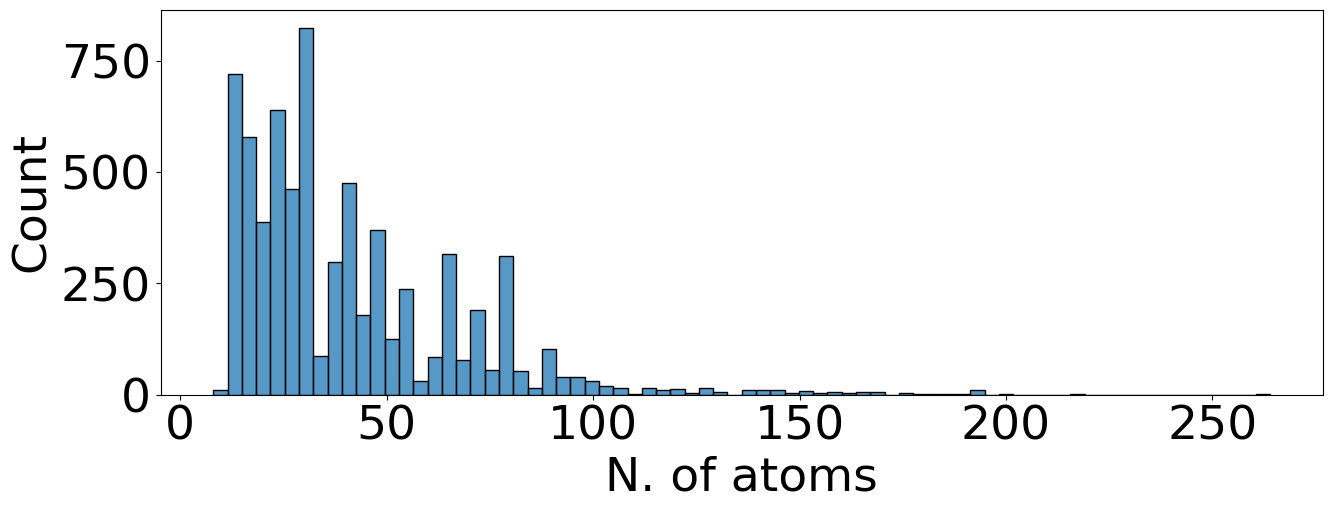

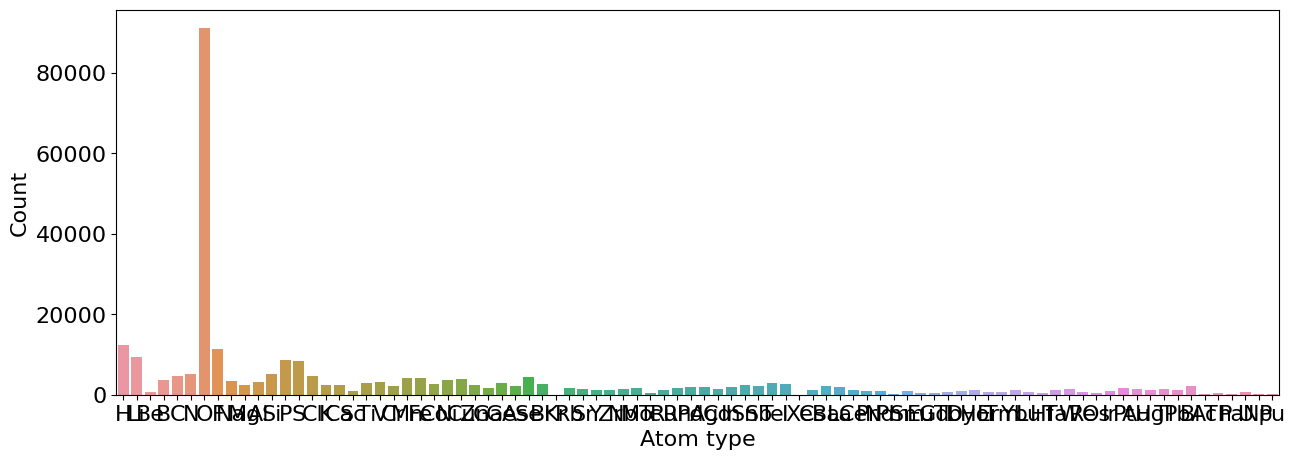

___________________________________________________________________________

QM9 



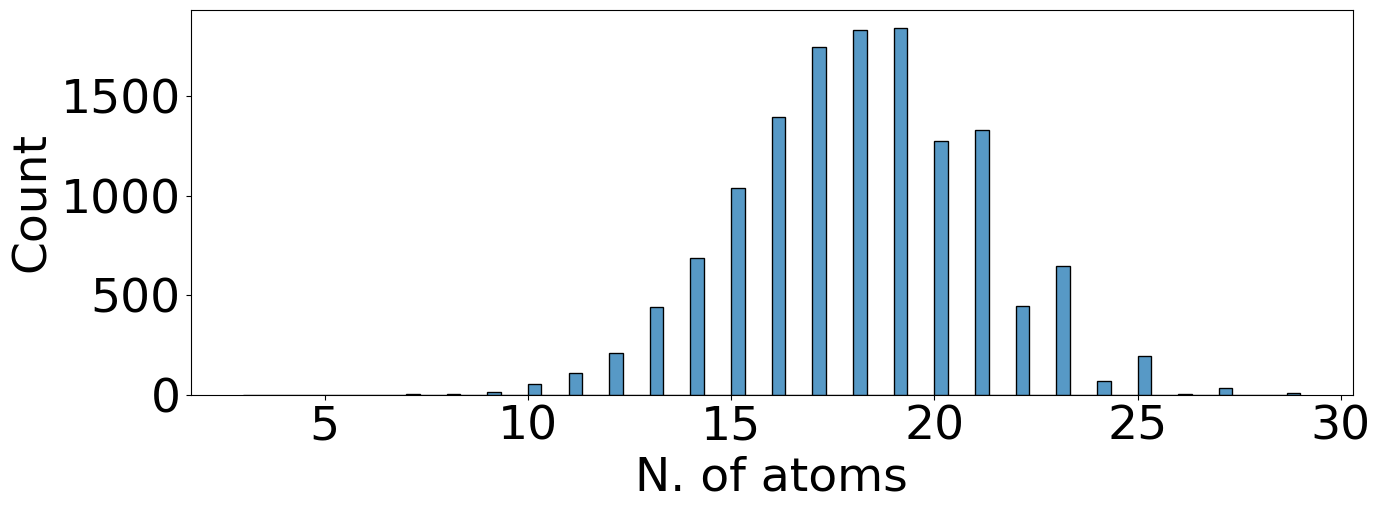

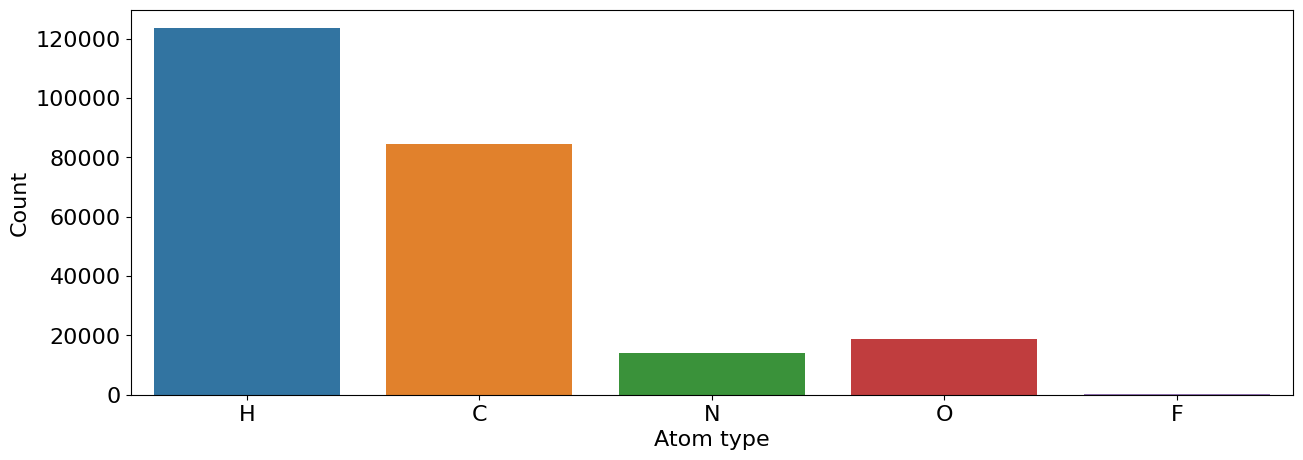

___________________________________________________________________________

GO 



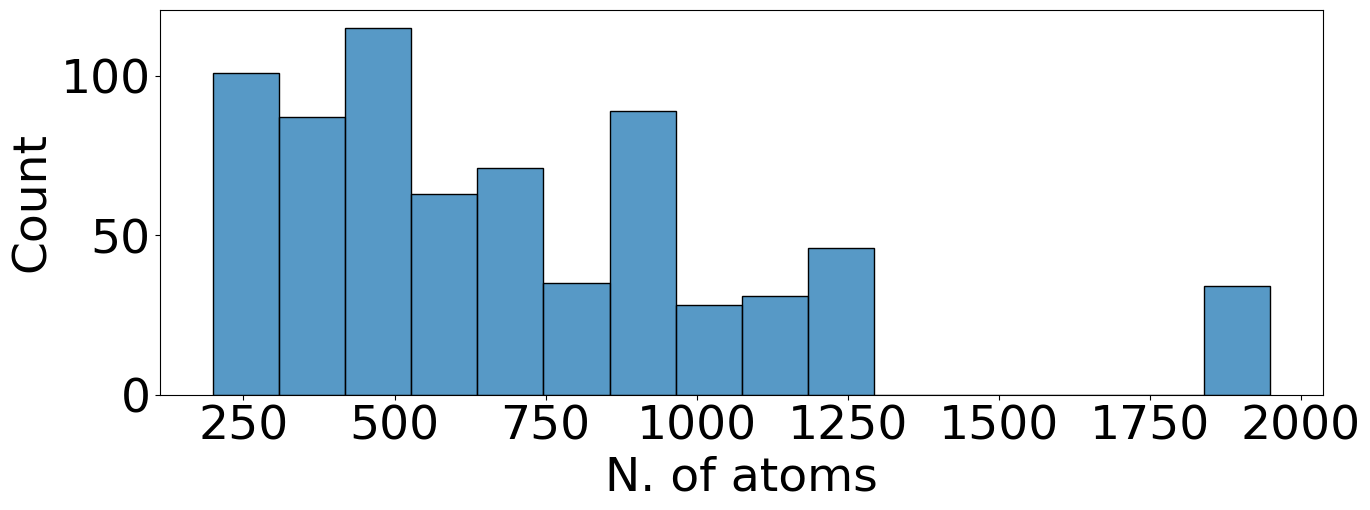

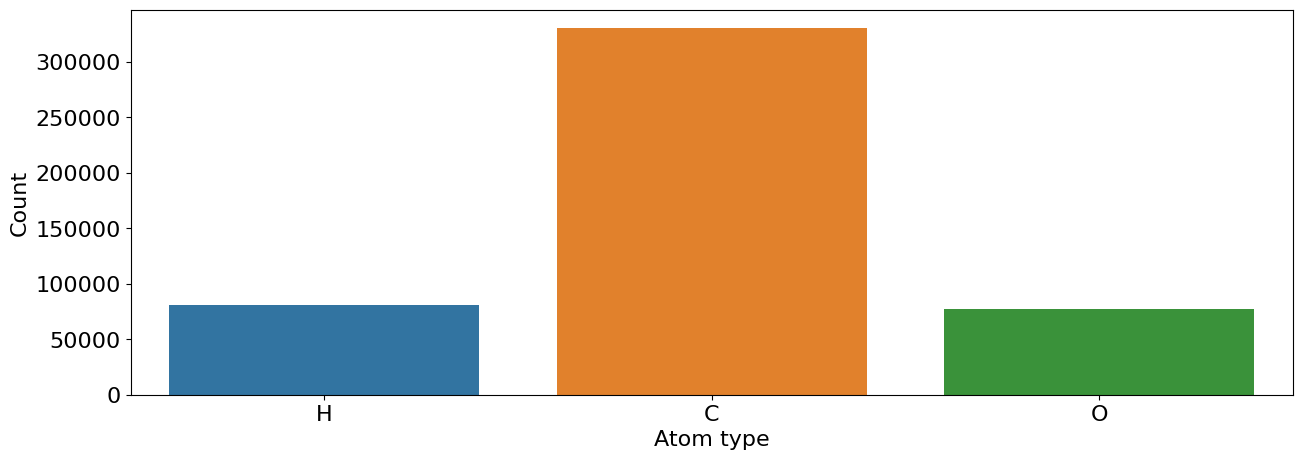

___________________________________________________________________________

joint 



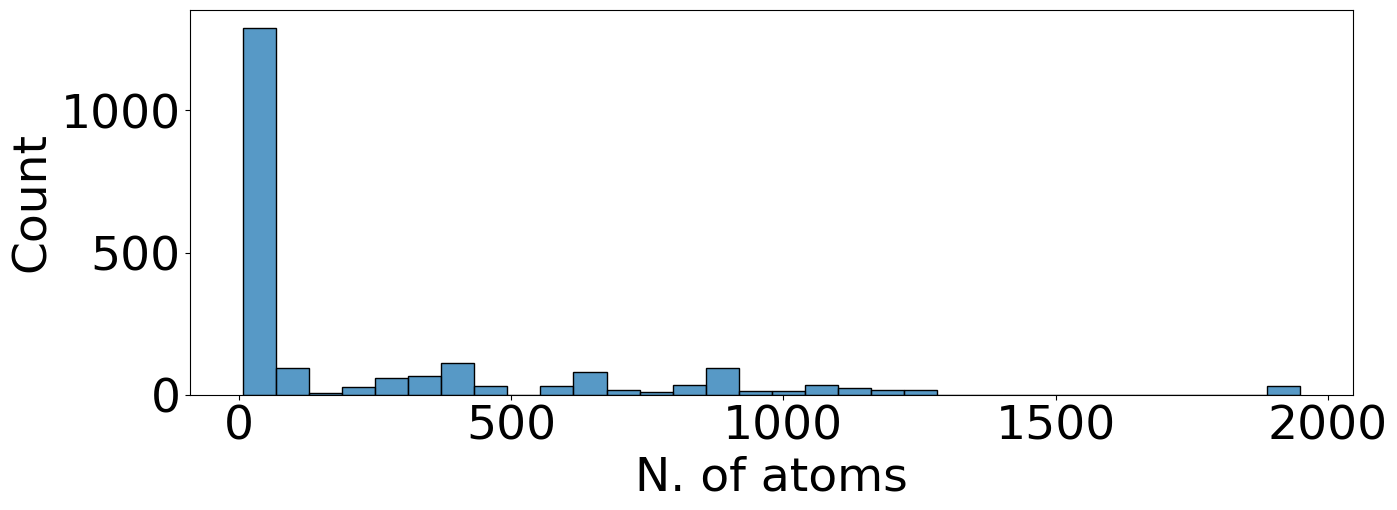

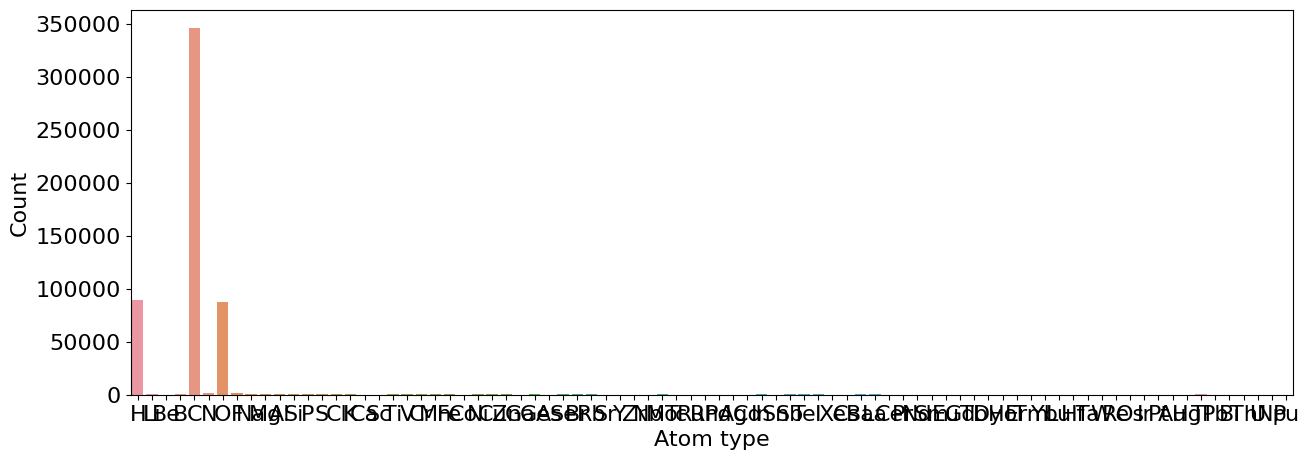

___________________________________________________________________________



In [13]:
DATASETS = ['MP','QM9','GO','joint']

for dataset in DATASETS:
    print(dataset,'\n')
    node_types = np.concatenate([g.ndata['node_type'] for g in graphs[dataset]])
    num_nodes = np.array([g.num_nodes() for g in graphs[dataset]])
    unique_node_types,counts = np.unique(node_types,return_counts=True)

    plt.rc('font', size=34) 
    plt.figure(figsize = (15,5))
    ax = plt.subplot(111)
    # ax.title.set_text('Atom count per structure')
    sns.histplot(num_nodes,ax=ax)
    ax.set_xlabel('N. of atoms')
    plt.show()


    plt.rc('font', size=16) 
    plt.figure(figsize = (15,5))
    ax = plt.subplot(111)
    # ax.title.set_text('Atom type counts')
    sns.barplot(x=[mg.Element.from_Z(z).symbol for z in unique_node_types],y=counts,ax=ax)
    ax.set_xticklabels(ax.get_xticklabels())
    ax.set_xlabel('Atom type')
    ax.set_ylabel('Count')

    plt.show()
    print('___________________________________________________________________________\n')

In [8]:
def get_cmap():
    df_colors = pd.read_csv("https://raw.githubusercontent.com/CorySimon/JMolColors/master/jmolcolors.csv")

    colors = ['#000000']
    for i in range(1,95):
        atom = mg.Element.from_Z(i).name
        r = df_colors[df_colors['atom'] == atom]['R'].values[0]
        g = df_colors[df_colors['atom'] == atom]['G'].values[0]
        b = df_colors[df_colors['atom'] == atom]['B'].values[0]
        colors.append('#{:02x}{:02x}{:02x}'.format(r, g, b))

    cmap = LinearSegmentedColormap.from_list('Atoms',colors)
    return colors, cmap

colors, cmap = get_cmap()

def plot_graph(g,attention=None,title='',ax=None, mask = None, predictions = None):

    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax  = fig.add_subplot(projection='3d',title=title)
    else: ax.set_title(title)
    positions = g.ndata['pos']
    atomic_numbers = g.ndata['node_type']
    edges_src,edges_dst= g.edges()

    scatter = ax.scatter(positions[:,0],positions[:,1],positions[:,2],s=atomic_numbers*10,c=atomic_numbers,cmap = cmap, vmin=0, vmax=len(colors))
    ax.view_init(azim=0, elev=90)
    ax.grid(False)
    if mask is not None: 
        ax.scatter(positions[mask,0],positions[mask,1],positions[mask,2],
                   s=atomic_numbers[mask]*15,
                   facecolors='none', 
                   edgecolors='gray',
                   linewidths=3.0,
                   alpha=0.5)
        if predictions is not None: 
            right = (atomic_numbers == predictions)
            wrong = mask & ~right 
            right = mask & right 
            

            ax.scatter(positions[right,0],positions[right,1],positions[right,2],s=atomic_numbers[right]*20,facecolors='none', edgecolors='green',linewidths=3.0)
            ax.scatter(positions[wrong,0],positions[wrong,1],positions[wrong,2],s=atomic_numbers[wrong]*20,facecolors='none', edgecolors='red',linewidths=3.0)

    a = scatter.legend_elements()
    legend1 = ax.legend(a[0],[mg.Element.from_Z(int(s[14:-2])).name for s in a[1]],loc="best", title="Element Types")
    ax.add_artist(legend1)
    for i,(src,dst) in enumerate(zip(edges_src,edges_dst)):
        sx ,sy, sz = positions[src]
        dx ,dy, dz = positions[dst]
        lx,ly,lz =np.linspace(sx,dx,10),np.linspace(sy,dy,10),np.linspace(sz,dz,10)
        ax.plot(lx,ly,lz, c='black', alpha = 0.5 if attention is None else attention[i])
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('c')
    return ax


def graph2xyz(graph):
    return f"{graph.num_nodes()}\n\n"+\
            "\n".join([f"{mg.Element.from_Z(graph.ndata['node_type'][i]).name} {graph.ndata['pos'][i][0]} {graph.ndata['pos'][i][1]} {graph.ndata['pos'][i][2]}" 
                       for i in range(graph.num_nodes())])

def getView(graph):
    #First we assign the py3Dmol.view as view
    view=py3Dmol.view()
    #The following lines are used to add the addModel class
    #to read the PDB files of chain B and C
    view.addModel(graph2xyz(graph),'xyz',{'bondLength':0.5})

    #Here we set the background color as white
    view.setBackgroundColor('white')
    #Here we set the visualization style for chain B and C
    # view.setStyle({'chain':'A'},{"stick": {'color': 'black'}})
    view.setStyle({'stick': {'opacity':0.6 , 'radius':0.05,'color':'black'}})

    for i in range(graph.num_nodes()):
        atom_line = 'H {:f} {:f} {:f}\n'.format( *graph.ndata['pos'][i])
        atom_model = '1\n\n' + atom_line
        view.addModel(atom_model, 'xyz')
        # color = get_color_based_on_atom_type(graph.ndata['node_type'][i],0,7)
        node_type = graph.ndata['node_type'][i].item()
        # color = get_color(mg.Element.from_Z(node_type).name)
        color = colors[node_type]

        view.setStyle({'model': -1}, 
                      {'sphere': {'color': color, 'radius':node_type/40}},)

    #Zooming into all visualized structures 
    view.zoomTo()
#     view = v.rotate(180,'y')
#     view = v.rotate(180,'x')
#     view = v.rotate(90,'z')
    return view

In [9]:
def compute_attentions(model,g,nfeats,efeats):
    attentions = []
    nfeats = model.gat.embedding(nfeats)
    for layer in model.gat.convs: 
        nfeats,efeats,attn = layer(g,nfeats,efeats,get_attention=True)#.view(g.num_nodes(),-1)    
        nfeats = model.gat.activation(nfeats.view(g.num_nodes(),-1))
        efeats = model.gat.activation(efeats.view(g.num_edges(),-1))    
        attentions.append(attn)

    out_feats,_,attn = model.classifier(g,nfeats,efeats,get_attention=True)
    out_feats = out_feats.mean(dim=1)
    attentions.append(attn)
    return F.softmax(out_feats,dim=1),attentions


def display_selector(g,attns,name='',mask=None,predictions=None):

    is_matplotlib_inline = matplotlib.get_backend()=="module://matplotlib_inline.backend_inline"
    # Create the list of plots
    plots = []
    plot_idx = 0

    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            plots.append((f'att{i}_{j}',att))

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111,projection='3d')

    # Create the dropdown widget and buttons
    dropdown_plot_selector = Dropdown(options=[plot[0] for plot in plots])
    prevButton = Button(description="<")
    nextButton = Button(description=">")
    # Display them
    box = HBox([prevButton,dropdown_plot_selector,nextButton])
    display.display(box)

    # Workaround to dinamically show plots when inline
    if is_matplotlib_inline:
        hdisplay_img = display.display(display_id=True)
        plt.close()

    def plot_selector(change):
        nonlocal plot_idx,prevButton,nextButton
        selected_plot = dropdown_plot_selector.value
        for i,(title,att) in enumerate(plots):
            if title == selected_plot: 
                ax.clear()
                if name: title = name +" - " + title
                plot_graph(g.cpu(),attention=att.numpy(),title=title,mask=mask, predictions=predictions,ax=ax)
                plot_idx = i
                if is_matplotlib_inline:
                    hdisplay_img.update(fig)
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1

    def swipe(backward = False):
        nonlocal plot_idx,prevButton,nextButton
        if not backward: 
            if 0 < len(plots)-1:
                 plot_idx += 1
        elif plot_idx > 0: 
            plot_idx -= 1
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1
        dropdown_plot_selector.value = plots[plot_idx][0]
        dropdown_plot_selector.selected_label = plots[plot_idx][0]
        plot_selector(None)

    dropdown_plot_selector.observe(plot_selector, names='value')
    prevButton.on_click(lambda x : swipe(backward = True))
    nextButton.on_click(lambda x : swipe(backward = False))
    prevButton.disabled = True


    plot_selector(None)
    return


def accuracy_report(labels,preds):
    print("accuracy:",accuracy_score(labels,preds))

    labels_unique = np.unique(labels)
    f1 = f1_score(labels,preds,average=None)
    print("f1_score:")
    for i, label in enumerate(labels_unique):
        print(f'\t{mg.Element.from_Z(label).name}: {f1[i]}')
    print("\tavg(macro):", f1_score(labels,preds,average='macro'))
    print("\tavg(weighted):", f1_score(labels,preds,average='weighted'))
    print()
    print('Labels counts:', ',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(labels,return_counts=True)).T]))
    print('Prediction counts:',',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(preds,return_counts=True)).T]))
    return

def plot_confusion_matrix(labels,preds,label_mappings=None,figsize=None,normalize = None):
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    if label_mappings is not None:
        lab = list(label_mappings.keys())
        lab_disp = list(label_mappings.values())
    else:
        lab,lab_disp = None,None
        
    include_values = len(label_mappings) < 30

    cm = confusion_matrix(labels,preds,labels=lab,normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lab_disp)
    disp.plot(include_values=include_values,ax=ax)
    plt.show()

In [21]:
dataset = 'QM9'
idx = 1632 # numpy.random.randint(0,len(graphs))
print(idx)

g = graphs[dataset][idx]
getView(g).show()

1632


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

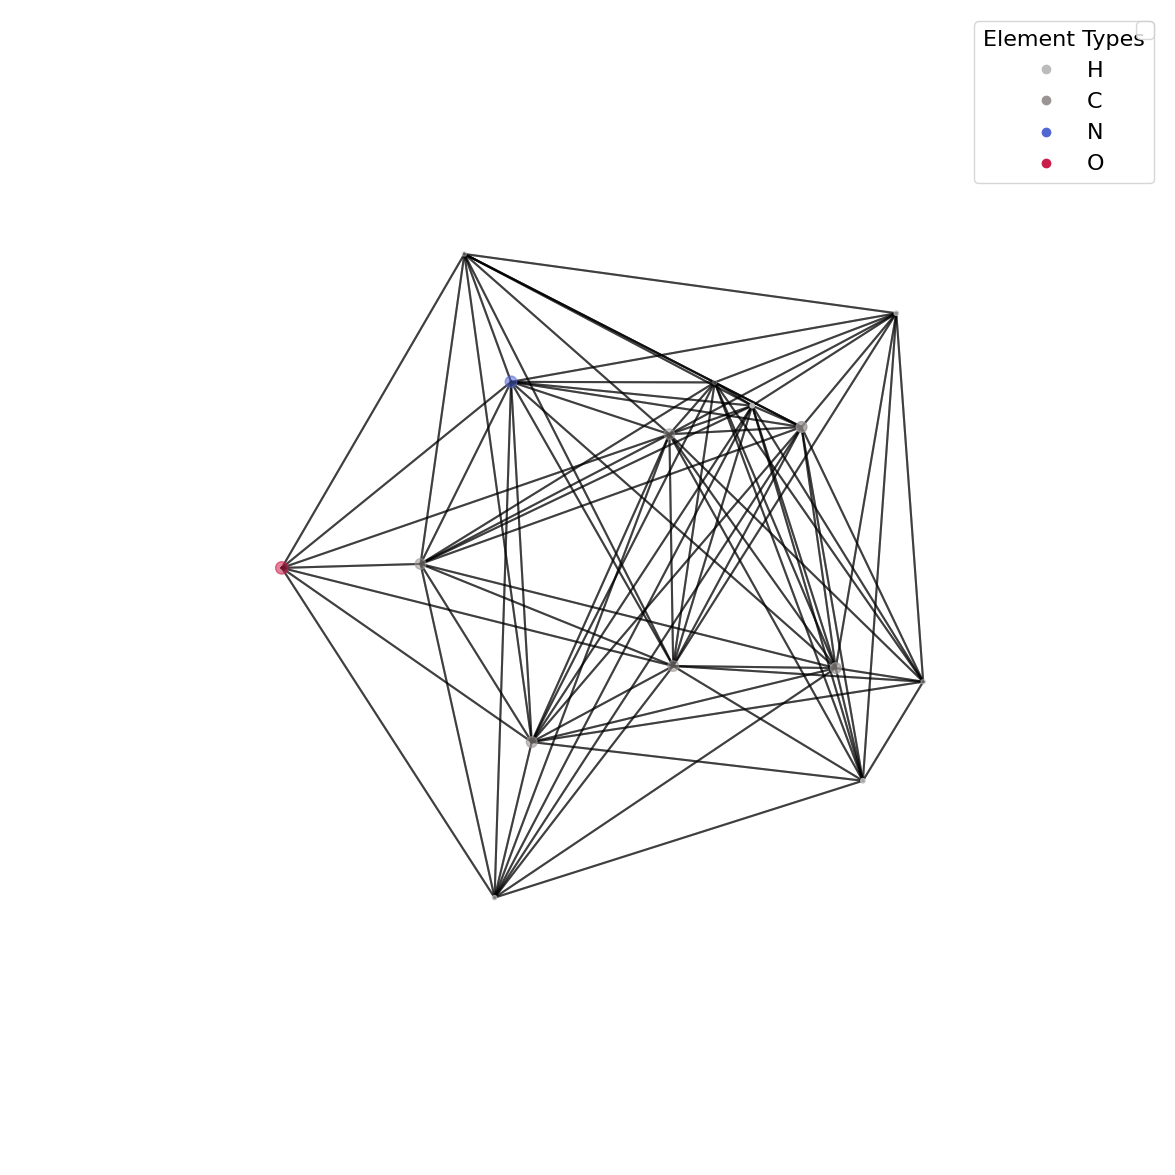

In [22]:
plt.figure(figsize=(15,15))
ax = plt.subplot(111,projection='3d')
plot_graph(g,ax=ax)
ax.axis('off')
ax.legend([])
plt.show()

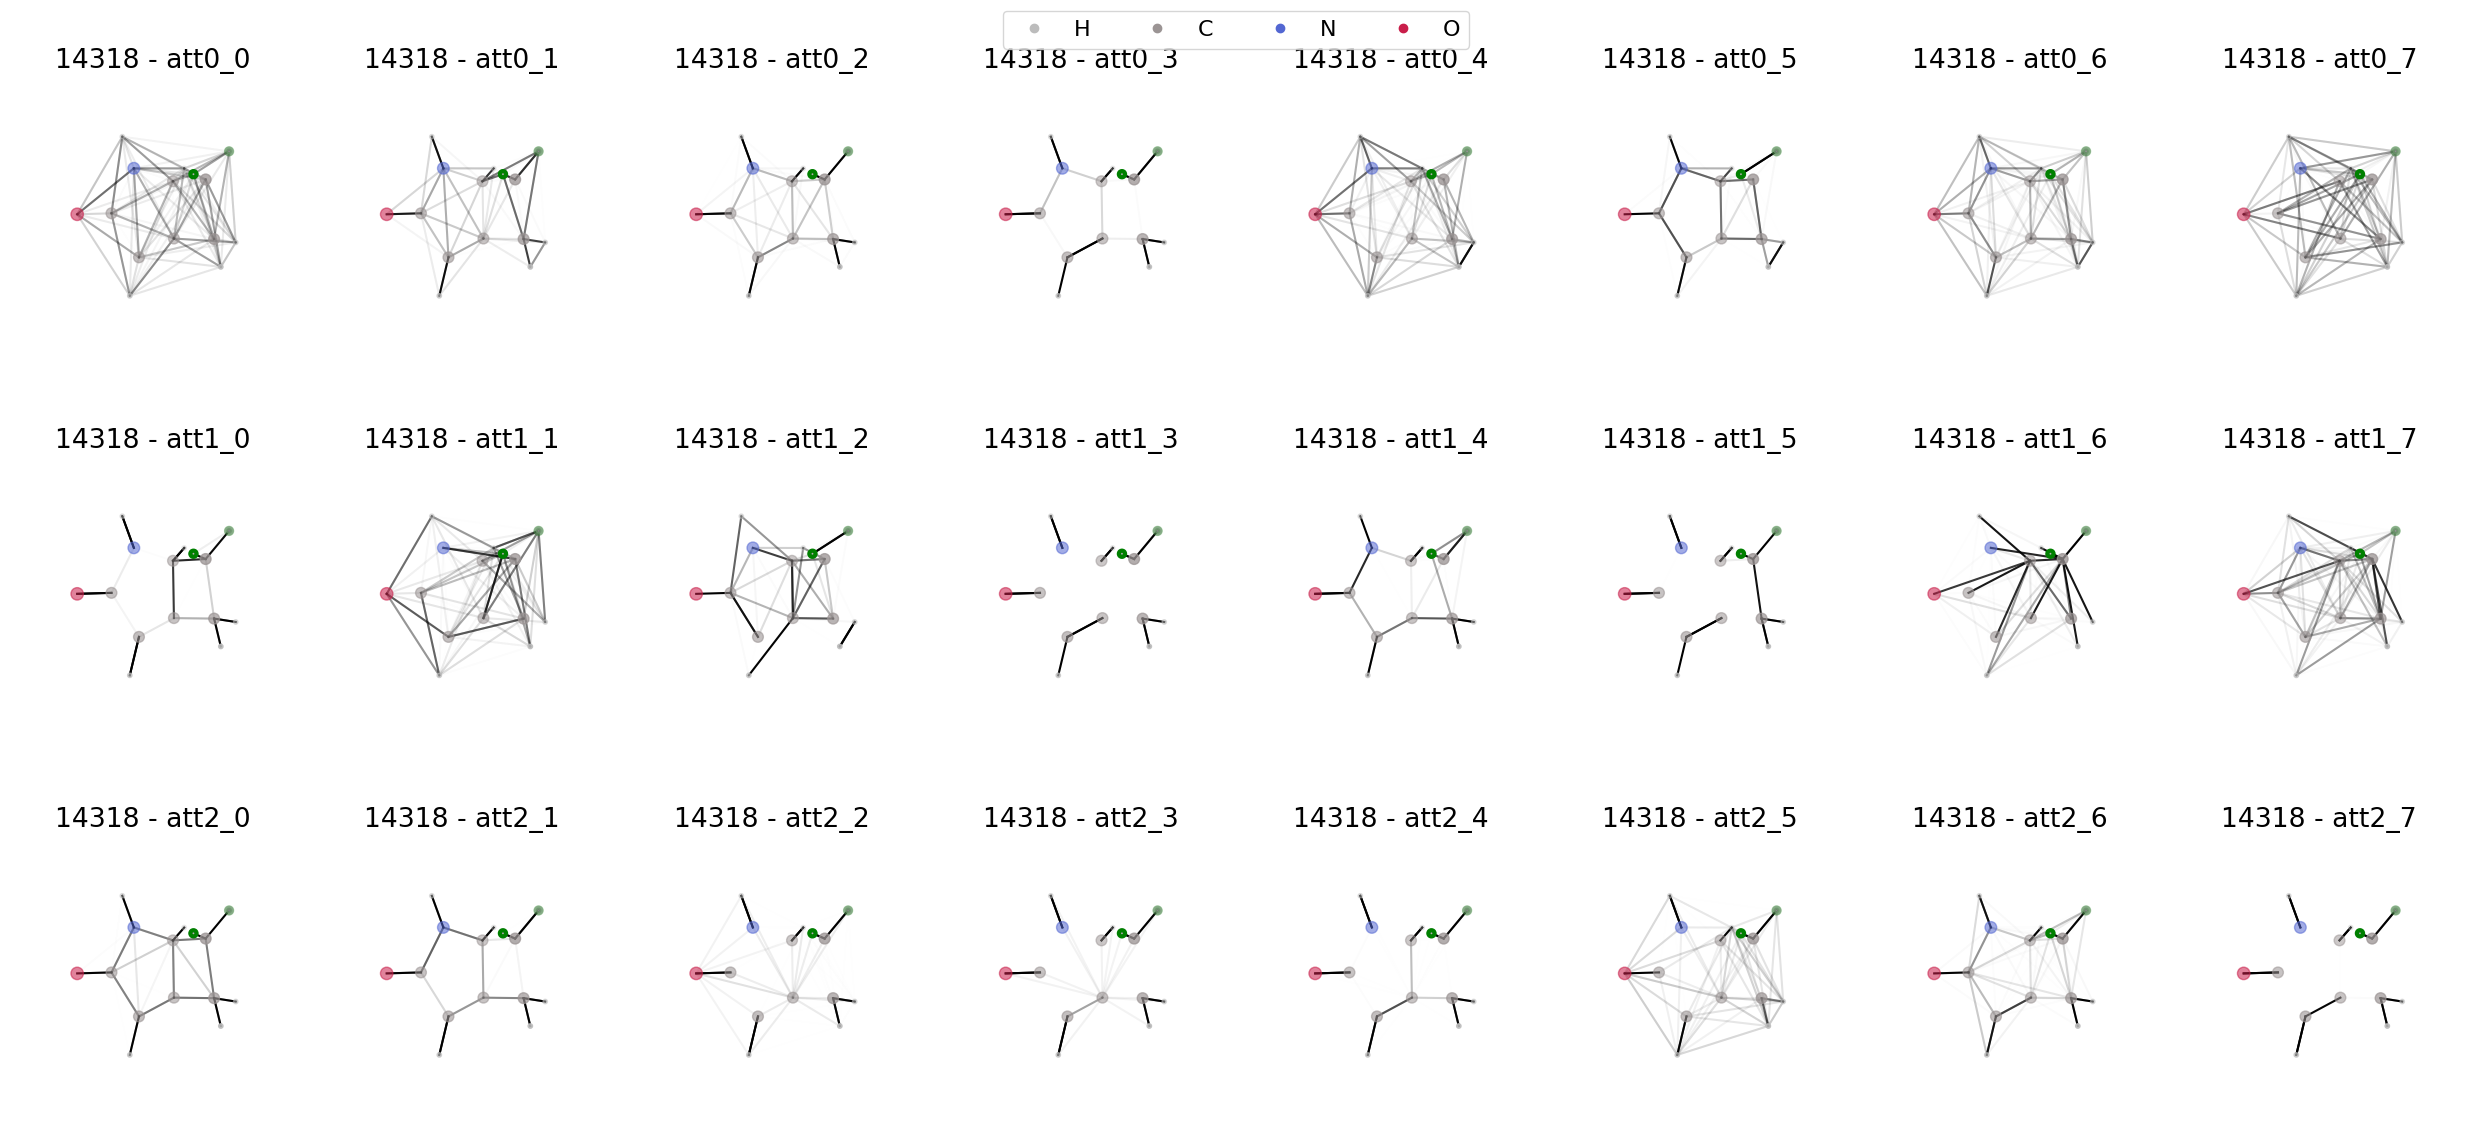

In [26]:
def display_attn_grid(g,attns,prefix = None, mask = None,preds = None):
    fig,axs = plt.subplots(3,8,subplot_kw={'projection':'3d'})
    fig.set_size_inches(25,12)
    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            if prefix is not None: title = f'{prefix} - att{i}_{j}'
            else: title = f'att{i}_{j}'
            plot_graph(g,attention=att.numpy(),title=title,mask = mask, predictions = preds,ax=axs[i,j])
            axs[i,j].axis('off')
            
            axs[i,j].get_legend().set_visible(False)
    lines = axs[0,0].get_legend().get_lines()
    texts = [e.get_text() for e in axs[0,0].get_legend().get_texts()]
    fig.legend(lines,texts,loc='upper center', ncol=8)
    plt.tight_layout()
    plt.show()

    
model = PLEGATNodePredictor.load_from_checkpoint('/home/tomcort/MaMoMo/models/2-QM9/model.ckpt')
model = model.to('cpu')
g = g.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = model.mask_labels(node_types)
    efeats = g.edata['bond_dist_exp']
    logits,attns = compute_attentions(model.net,g,nfeats,efeats)

display_attn_grid(g,attns,f'{target_dicts[dataset]["graphs_ids"][idx]}',mask,logits.argmax(dim=1))

### Display a specific attention map

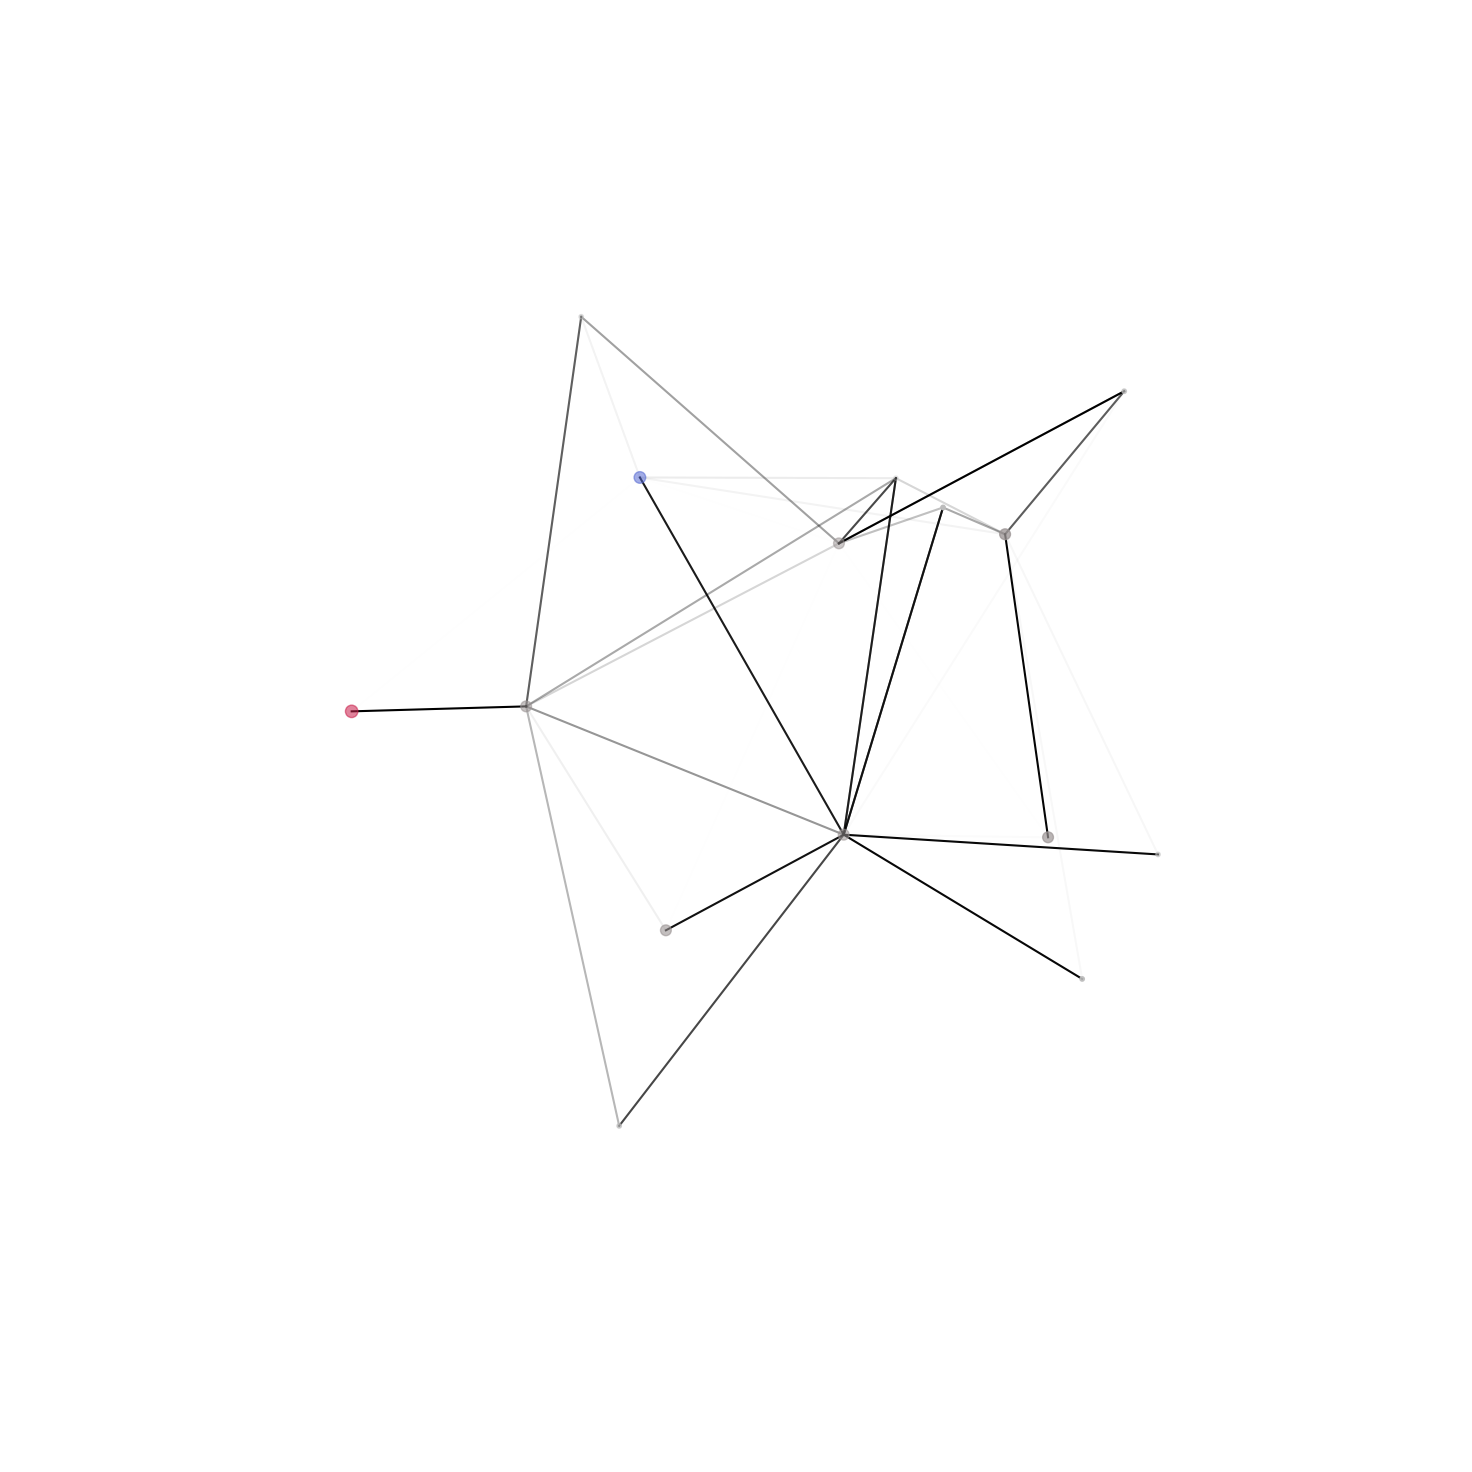

In [25]:
att = attns[1][:,0].squeeze()

fig = plt.figure(figsize=(15,15))
ax = plt.subplot(111,projection='3d')
plot_graph(g,attention=att.numpy(),ax=ax)
ax.axis('off')
ax.get_legend().set_visible(False)
fig.tight_layout()
plt.show()

### Produce predictions for task 1-property predictions

In [47]:
targets = {'MP': ['formation_energy_per_atom','band_gap'],
           'GO': ['Fermi_energy', 'total_energy','electron_affinity', 'electronegativity', 'ionization_potential',],
           'QM9':['E_HOMO', 'E_LUMO', 'band_gap', 'dipole_moment', 'internal_energy_0K',
                  'internal_energy_298.15K', 'isotropic_polarizaibility', 'enthalpy_298.15K', 
                  'electronic_spatial_extent', 'free_energy_298.15K', 'heat_capacity_298.15K',
                  'zero_point_vibrational_energy'],
          }

In [17]:
from pathlib import Path

def get_checkpoint_name(checkpoints_path: Path):
    best_loss = sorted([
        model
        for model in checkpoints_path.iterdir()
        if str(model.stem).startswith("best_loss")
    ])

    return str(best_loss[0])

class MyDataset(torch.utils.data.Dataset):
    def __init__(self,graphs,targets):
        super(MyDataset).__init__()
        self.graphs = graphs
        self.targets=targets
        
    def __getitem__(self,idx):
        return self.graphs[idx],self.targets[idx]
    
    def __len__(self):
        return len(self.graphs)
    
def get_predictions(model,dataset):
    model = model.to(device)
    
    result = {'id':[],
              'target':[],
              'predicted':[],
             }
    
    transform = GaussianExpansion(initial=0,final=6,num_centers=100,width=0.5)

    loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=100)

    with torch.no_grad():
        for g,(i,y) in tqdm(loader): 
            g= g.to(device)
            efeats = g.edata['bond_dist_exp'].to(device)
            nfeats = g.ndata['node_type'].to(device)

            output = model(g,nfeats,efeats)
            result['id'].append(i.cpu().numpy())
            result['predicted'].append(output.squeeze().cpu().numpy())
            result['target'].append(y.cpu().numpy())

    result = {k:np.concatenate(v,axis=0) for k,v in result.items() }
    return pd.DataFrame(result)


for k,tlist in targets.items():
    result = pd.DataFrame(target_dicts[k]['graphs_ids'],columns=['id'])
    for t in tlist:
        modelpath = get_checkpoint_name(Path(f'/home/tomcort/MaMoMo/models/1-{k}/{t}'))
        model = PLEGATRegressor.load_from_checkpoint(modelpath)
        dataset = MyDataset(graphs[k],list(zip(target_dicts[k]['graphs_ids'],target_dicts[k][t])))
        predictions = get_predictions(model,dataset)
        predictions[f'{t}_err_abs'] = (predictions['target']-predictions['predicted']).abs()
        predictions = predictions.rename(columns={"target": f"{t}_real", "predicted": f"{t}_pred"})
        result = result.merge(predictions,on='id',how='inner',sort=True,validate='1:1')
    result.to_csv(f'prediction_results/1-property/{k}.csv')

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [18]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,graphs,targets):
        super(MyDataset).__init__()
        self.graphs = graphs
        self.targets=targets
        
    def __getitem__(self,idx):
        return self.graphs[idx],self.targets[idx]
    
    def __len__(self):
        return len(self.graphs)
    
def get_predictions(model,dataset):
    model = model.to(device)
    
    result = {'id':[],
              'target':[],
              'predicted':[],
             }
    
    transform = GaussianExpansion(initial=0,final=6,num_centers=100,width=0.5)

    loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=100)

    with torch.no_grad():
        for g,(i,y) in tqdm(loader): 
            g= g.to(device)
            efeats = g.edata['bond_dist_exp'].to(device)
            nfeats = g.ndata['node_type'].to(device)

            output = model(g,nfeats,efeats)
            result['id'].append(i.cpu().numpy())
            result['predicted'].append(output['graph'].squeeze().cpu().numpy())
            result['target'].append(y.cpu().numpy())

    result = {k:np.concatenate(v,axis=0) for k,v in result.items() }
    return pd.DataFrame(result)


for k,tlist in targets.items():
    result = pd.DataFrame(target_dicts[k]['graphs_ids'],columns=['id'])
    for t in tlist:
        modelpath = get_checkpoint_name(Path(f'/home/tomcort/MaMoMo/models/4-{k}/{t}'))
        model = PLEGATNodePredictorAndRegressor.load_from_checkpoint(modelpath)
        dataset = MyDataset(graphs[k],list(zip(target_dicts[k]['graphs_ids'],target_dicts[k][t])))
        predictions = get_predictions(model,dataset)
        predictions[f'{t}_err_abs'] = (predictions['target']-predictions['predicted']).abs()
        predictions = predictions.rename(columns={"target": f"{t}_real", "predicted": f"{t}_pred"})
        result = result.merge(predictions,on='id',how='inner',sort=True,validate='1:1')
    result.to_csv(f'prediction_results/4-node+property/{k}.csv')

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [28]:
for dataset in ['QM9','GO','MP']:
    print(dataset,'\n')
    df = pd.read_csv(f'prediction_results/1-property/{dataset}.csv')
    for target in targets[dataset]:
        print(f'{target}:{df[f"{target}_err_abs"].mean():.3f}')
    print('____________________________________________\n')

QM9 

E_HOMO:0.004
E_LUMO:0.003
band_gap:0.004
dipole_moment:0.241
internal_energy_0K:2.557
internal_energy_298.15K:3.329
isotropic_polarizaibility:0.831
enthalpy_298.15K:2.671
electronic_spatial_extent:40.723
free_energy_298.15K:3.428
heat_capacity_298.15K:0.202
zero_point_vibrational_energy:0.001
____________________________________________

GO 

Fermi_energy:0.048
total_energy:13280.224
electron_affinity:0.078
electronegativity:0.066
ionization_potential:0.074
____________________________________________

MP 

formation_energy_per_atom:0.079
band_gap:0.389
____________________________________________



In [29]:
for dataset in ['QM9','GO','MP']:
    print(dataset,'\n')
    df = pd.read_csv(f'prediction_results/4-node+property/{dataset}.csv')
    for target in targets[dataset]:
        print(f'{target}:{df[f"{target}_err_abs"].mean():.3f}')
    print('____________________________________________\n')

QM9 

E_HOMO:0.008
E_LUMO:0.008
band_gap:0.011
dipole_moment:0.332
internal_energy_0K:4.720
internal_energy_298.15K:4.588
isotropic_polarizaibility:0.851
enthalpy_298.15K:4.117
electronic_spatial_extent:37.401
free_energy_298.15K:4.704
heat_capacity_298.15K:0.260
zero_point_vibrational_energy:0.006
____________________________________________

GO 

Fermi_energy:0.128
total_energy:29281.578
electron_affinity:0.100
electronegativity:0.068
ionization_potential:0.425
____________________________________________

MP 

formation_energy_per_atom:0.124
band_gap:0.434
____________________________________________



In [67]:
for dataset in ['QM9','GO','MP']:
    print(dataset,'\n')
    df = pd.read_csv(f'prediction_results/4-node+property/{dataset}.csv')
    for target in targets[dataset]:
        print(f'{target}:{df[f"{target}_err_abs"].mean():.3f}')
    print('____________________________________________\n')

QM9 

E_HOMO:0.009
E_LUMO:0.009
band_gap:0.012
dipole_moment:0.416
internal_energy_0K:7.192
internal_energy_298.15K:7.054
isotropic_polarizaibility:1.187
enthalpy_298.15K:6.770
electronic_spatial_extent:45.361
free_energy_298.15K:7.111
heat_capacity_298.15K:0.366
zero_point_vibrational_energy:0.005
____________________________________________

GO 

Fermi_energy:0.049
total_energy:12427.088
electron_affinity:0.087
electronegativity:0.070
ionization_potential:0.077
____________________________________________

MP 

formation_energy_per_atom:0.110
band_gap:0.441
____________________________________________



In [36]:
df = pd.read_csv('/home/tommaso/xyz_files_GO/prediction_results.csv')
for target in targets['GO']:
    print(f'{target}:{(df[f"{target}_real"]-df[f"{target}_predicted"]).abs().mean():.3f}')

Fermi_energy:0.047
total_energy:3.920
electron_affinity:0.084
electronegativity:0.067
ionization_potential:0.064


### Predictions for task 2 and 4 - node

In [71]:
def get_predictions(model,dataset):
    model = model.to(device)
    ids = []
    preds = {'node':[],
             'graph':[],
             }
    targets = {'node':[],
             'graph':[],
             }

    loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=100)

    with torch.no_grad():
        for g,(i,y) in tqdm(loader): 
            g= g.to(device)
            efeats = g.edata['bond_dist_exp'].to(device)
            node_types = g.ndata['node_type'].to(device)
            nfeats,mask = model.mask_labels(node_types)

            output = model(g,nfeats,efeats)
            preds['node'].append(output['node'].argmax(dim=1)[mask].cpu().numpy())
            preds['graph'].append(output['graph'].squeeze().cpu().numpy())

            targets['node'].append(node_types[mask].cpu().numpy())
            targets['graph'].append(y.cpu().numpy())
                
            ids.append(i.cpu().numpy())
    ids = np.concatenate(ids,axis=0)
    preds = {k:np.concatenate(v,axis = 0) for k,v in preds.items()}
    targets = {k:np.concatenate(v,axis = 0) for k,v in targets.items()}
    
    return preds,targets,ids

def accuracy_report(labels,preds):
    print("accuracy:",accuracy_score(labels,preds))

    labels_unique = np.unique(labels)
    f1 = f1_score(labels,preds,average=None)
    print("f1_score:")
    for i, label in enumerate(labels_unique):
        print(f'\t{mg.Element.from_Z(label).name}: {f1[i]}')
    print("\tavg(macro):", f1_score(labels,preds,average='macro'))
    print("\tavg(weighted):", f1_score(labels,preds,average='weighted'))
    print('Labels counts:', ',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(labels,return_counts=True)).T]))
    print('Prediction counts:',',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(preds,return_counts=True)).T]))
    return

def accuracy_str(labels,preds):
    labels_unique = np.unique(labels)
    f1 = f1_score(labels,preds,average=None)
    result = f"accuracy: {accuracy_score(labels,preds)}\nf1_score:\n"
    for i, label in enumerate(labels_unique):
        result+= f'\t{mg.Element.from_Z(label).name}: {f1[i]}\n'
    result +=  f"\tavg(macro): {f1_score(labels,preds,average='macro')}\n"
    result += f"\tavg(weighted): {f1_score(labels,preds,average='weighted')}\n"
    return result
    
for d in ['QM9','GO','MP','joint']:
    t = targets[d][0]
    print(d,'\n')
    node_report_str = f"{k}\n"

    result = pd.DataFrame(target_dicts[d]['graphs_ids'],columns=['id'])
    modelpath = get_checkpoint_name(Path(f'/home/tomcort/MaMoMo/models/2-{d}'))
    model = PLEGATNodePredictorAndRegressor.load_from_checkpoint(modelpath)

    dataset = MyDataset(graphs[d],list(zip(target_dicts[d]['graphs_ids'],target_dicts[d][t])))
    preds,labels,ids = get_predictions(model,dataset)
    
    preds,labels = preds['node'].astype(int),labels['node'].astype(int)
    node_report_str+=accuracy_str(labels,preds)
    accuracy_report(labels,preds)
    with open(f'prediction_results/2-node/{k}_accuracy_report.txt','w') as f:
        f.write(node_report_str)

QM9 



  0%|          | 0/134 [00:00<?, ?it/s]

accuracy: 0.9997083819363439
f1_score:
	H: 0.9999796188729237
	C: 0.999762202009393
	N: 0.9978954752718344
	O: 0.9990640459954538
	F: 1.0
	avg(macro): 0.9993402684299209
	avg(weighted): 0.9997083724007156
Labels counts: H:24532,  C:16821,  N:2851,  O:3740,  F:64
Prediction counts: H:24533,  C:16821,  N:2851,  O:3739,  F:64
GO 



  0%|          | 0/7 [00:00<?, ?it/s]

accuracy: 0.9999592298519024
f1_score:
	H: 1.0
	C: 0.9999697921701305
	O: 0.9998722452890451
	avg(macro): 0.9999473458197251
	avg(weighted): 0.9999592298519024
Labels counts: H:16248,  C:66208,  O:15655
Prediction counts: H:16248,  C:66208,  O:15655
MP 



  0%|          | 0/70 [00:00<?, ?it/s]

accuracy: 0.9653512316828899
f1_score:
	H: 0.9874002519949601
	Li: 0.9518576661433804
	Be: 0.927536231884058
	B: 0.985234899328859
	C: 0.9660144181256436
	N: 0.932274638019617
	O: 0.9958683339261772
	F: 0.9852744310575636
	Na: 0.9340892983699505
	Mg: 0.8935281837160751
	Al: 0.9409937888198757
	Si: 0.9688846337960746
	P: 0.9822385114180997
	S: 0.9755223880597016
	Cl: 0.975054229934924
	K: 0.946031746031746
	Ca: 0.928495197438634
	Sc: 0.9375
	Ti: 0.9407407407407408
	V: 0.9277978339350181
	Cr: 0.9271356783919597
	Mn: 0.9038340666247644
	Fe: 0.9312977099236641
	Co: 0.9211691762621789
	Ni: 0.9294199860237597
	Cu: 0.9070967741935484
	Zn: 0.9232209737827715
	Ga: 0.944
	Ge: 0.9452914798206279
	As: 0.9591346153846154
	Se: 0.9777052746057638
	Br: 0.9719264278799612
	Kr: 1.0
	Rb: 0.9491017964071857
	Sr: 0.9440789473684211
	Y: 0.925531914893617
	Zr: 0.948024948024948
	Nb: 0.9416058394160584
	Mo: 0.9244186046511629
	Tc: 0.9160305343511451
	Ru: 0.9161290322580645
	Rh: 0.9629629629629629
	Pd: 0.96774

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:59                                                                                   │
│                                                                                                  │
│   56 │   return result                                                                           │
│   57                                                                                             │
│   58 for d in ['QM9','GO','MP','joint']:                                                         │
│ ❱ 59 │   t = targets[d][0]                                                                       │
│   60 │   print(d,'\n')                                                                           │
│   61 │   node_report_str = f"{k}\n"                                                              │
│   62                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'joint'

In [72]:
for k,tlist in targets.items():
    result = pd.DataFrame(target_dicts[k]['graphs_ids'],columns=['id'])
    node_report_str = f"{k}\n"
    for t in tlist:
        node_report_str += t + '\n'
        modelpath = get_checkpoint_name(Path(f'/home/tomcort/MaMoMo/models/4-{k}/{t}'))
        model = PLEGATNodePredictorAndRegressor.load_from_checkpoint(modelpath)
        dataset = MyDataset(graphs[k],list(zip(target_dicts[k]['graphs_ids'],target_dicts[k][t])))
        preds,labels,ids = get_predictions(model,dataset)
        
        property_preds = pd.DataFrame({'id':ids,
                                       f'{t}_pred':preds['graph'],
                                       f'{t}_real':labels['graph'],
                                       f'{t}_err_abs':np.abs(preds['graph']-labels['graph'])
                                     })
        result = result.merge(property_preds,on='id',how='inner',sort=True,validate='1:1')
        preds,labels = preds['node'].astype(int),labels['node'].astype(int)
        node_report_str+=accuracy_str(labels,preds)
    result.to_csv(f'prediction_results/4-node+property/{k}.csv')    
    with open(f'prediction_results/4-node+property/{k}_accuracy_report.txt','w') as f:
        f.write(node_report_str)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]